In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from kinematics_and_rotation.dispersion import *

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 20,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

In [2]:
gaia_mc0 = pd.read_csv("gaia_mc2.csv")
print(np.shape(gaia_mc0))

# Cut out visual binaries.
gaia_mc1 = gaia_mc0.iloc[gaia_mc0.flag.values == 1]
print(np.shape(gaia_mc1), "no visual binaries or subgiants")

# Cut out stars with large vb uncertainties.
m = gaia_mc1.vb_err.values < 1.
print(np.shape(gaia_mc1.iloc[m]), "no large vb uncertainties")

m &= gaia_mc1.phot_g_mean_mag.values < 16.
print(np.shape(gaia_mc1.iloc[m]), "no faint stars")

# Cut out rapid rotators (synchronized binaries)
# m &= gaia_mc1.age.values > .5
# print(np.shape(gaia_mc1.iloc[m]), "no rapid rotators")

# Cut out very hot and very cold stars. The hot limit is usually 5000 and the cool usually 3500
mint, maxt = 3500, 5500
m &= (gaia_mc1.color_teffs.values < maxt) * (mint < gaia_mc1.color_teffs.values)
print(np.shape(gaia_mc1.iloc[m]), "no hot or cold stars")

# Try cutting out stars with latitudes greater than bmax degrees
# bmax = 20
bmax = 15
m &= (gaia_mc1.b.values < bmax)
print(np.shape(gaia_mc1.iloc[m]), "no high latitude stars")

gaia_mc = gaia_mc1.iloc[m]

(31357, 133)
(11700, 133) no visual binaries or subgiants
(11436, 133) no large vb uncertainties
(11272, 133) no faint stars
(11108, 133) no hot or cold stars
(7371, 133) no high latitude stars


In [3]:
gaia_mc.to_csv("stars_for_kinematic_plot.csv")

In [4]:
def binned_dispersion(x, y, nbins, method="rms"):
    
    d, N, mean = [np.zeros(nbins) for i in range(3)]
    bin_width = (max(x) - min(x))/nbins
    left_bin_edges = np.array([min(x) + i*bin_width for i in range(nbins)])
    right_bin_edges = left_bin_edges + bin_width
    mid_bin = left_bin_edges + .5*bin_width
    
    for i in range(nbins):
        m = (left_bin_edges[i] < x) * (x < right_bin_edges[i])
        mean[i] = np.mean(y[m])
        N[i] = sum(m)
        if method == "std":
            d[i] = np.std(y[m])
        elif method == "mad":
            d[i] = np.sqrt(np.median(y[m]))
        elif method == "rms":
            d[i] = np.sqrt(np.mean((y[m])**2))
    return left_bin_edges, d, d/np.sqrt(N), mean

In [5]:
binary_age, gap_age, teff_limit = .5, 1.06279416, 5000
old = (gaia_mc.age.values > gap_age) * (gaia_mc.color_teffs.values < teff_limit)
young = (gaia_mc.age.values < gap_age) * (gaia_mc.age.values > binary_age) \
    * (gaia_mc.color_teffs.values < teff_limit)
binaries = (gaia_mc.age.values < binary_age) * (gaia_mc.color_teffs.values < teff_limit)
# binaries = (gaia_mc.Prot < 6)

everything_else = old + young + binaries

# binary_age = .35
# non_binaries = gaia_mc.age.values > binary_age
# non_binaries = gaia_mc.Prot.values > 6

[ 0.204    3.46085  6.7177   9.97455 13.2314  16.48825 19.7451  23.00195
 26.2588  29.51565 32.7725  36.02935 39.2862  42.54305 45.7999  49.05675
 52.3136  55.57045 58.8273  62.08415]


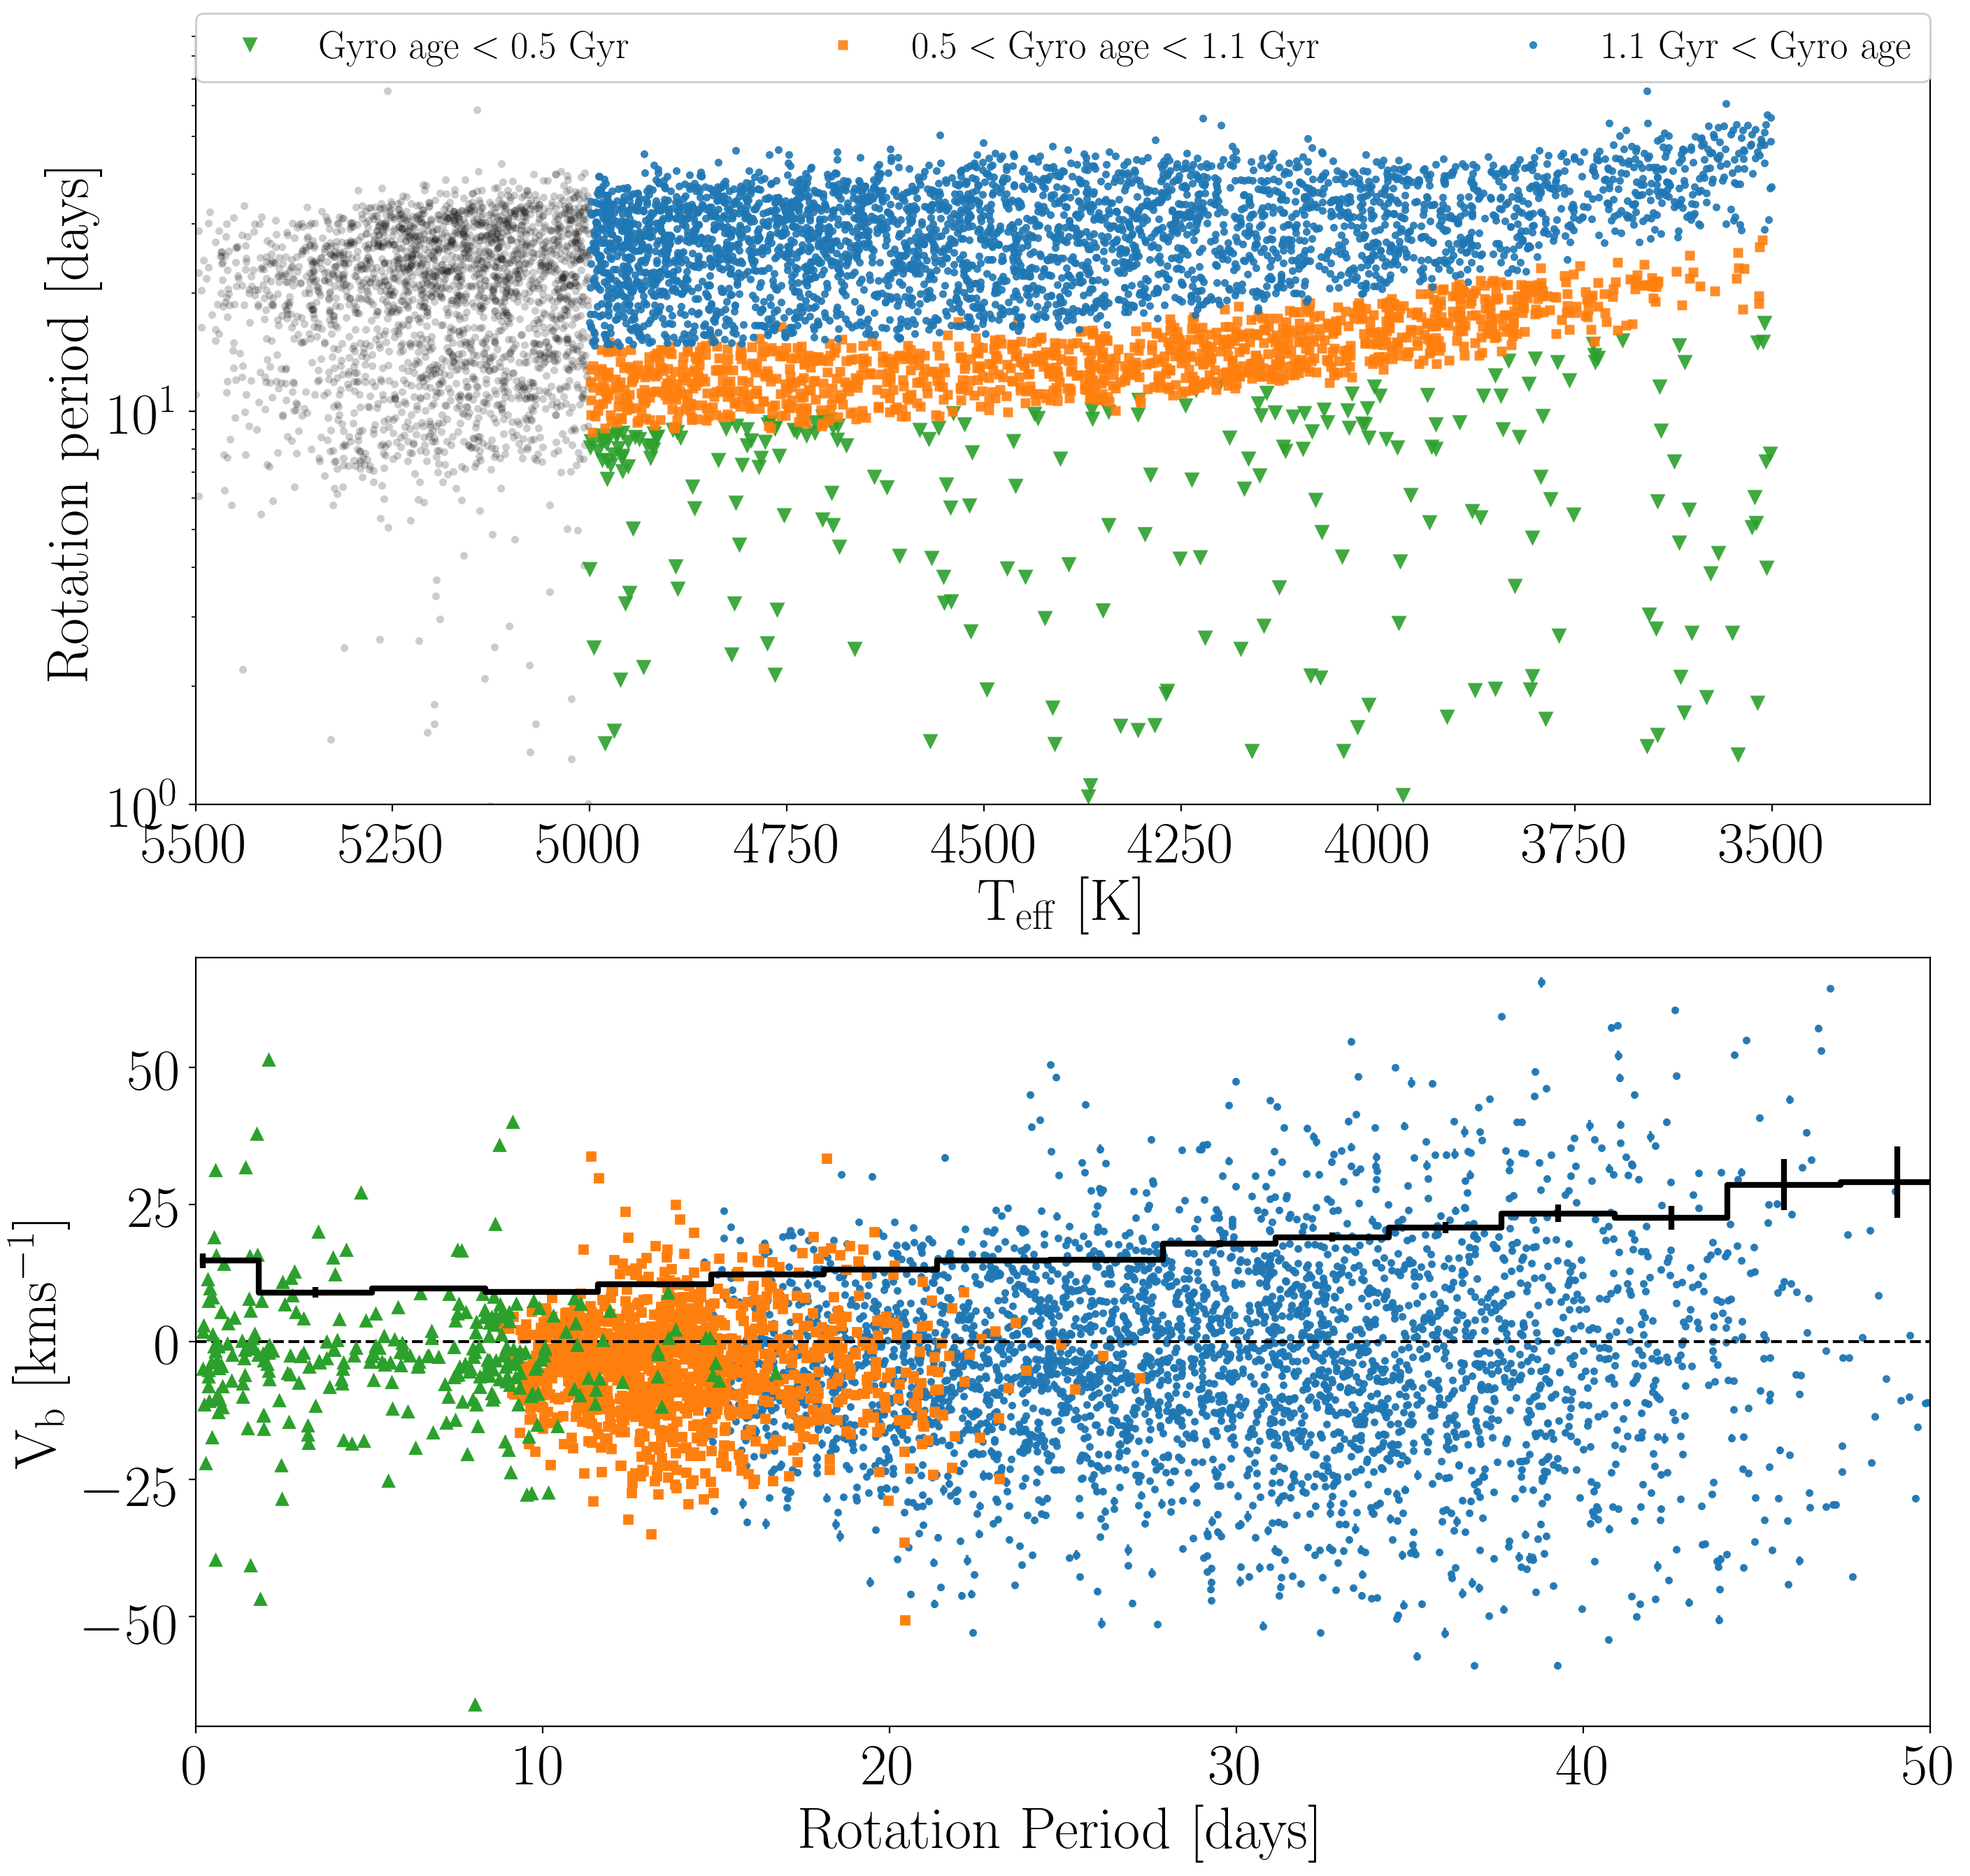

In [13]:
fig = plt.figure(figsize=(16, 16), dpi=200)

ax1 = fig.add_subplot(211)
al = .9

# ax1.plot(gaia_mc.color_teffs[non_binaries], gaia_mc.Prot[non_binaries],
#          "k.", zorder=0, alpha=.2, mec="none", ms=8, rasterized=True, label='_nolegend_')
# ax1.plot(gaia_mc.color_teffs[~non_binaries], gaia_mc.Prot[~non_binaries],
#          "C1v", zorder=1, ms=8, mec="none", alpha=.7, rasterized=True,
#          label="$\mathrm{Possible~binaries~(0.5~Gyr < Gyro~age)}$")

# All McQuillan-Gaia stars
plt.plot(gaia_mc.color_teffs[~everything_else], gaia_mc.Prot[~everything_else],
         "k.", zorder=0, alpha=.2, mec="none", ms=8, rasterized=True, label="")

# Binaries
plt.plot(gaia_mc.color_teffs[binaries], gaia_mc.Prot[binaries],
         "C2v", zorder=1, ms=8, mec="none", alpha=al, rasterized=True,
         label="$\mathrm{Gyro~age < 0.5~Gyr}$")

# Young stars
plt.plot(gaia_mc.color_teffs[young], gaia_mc.Prot[young],
         "C1s", zorder=1, ms=5, mec="none", alpha=al, rasterized=True,
         label="$\mathrm{0.5 < Gyro~age < 1.1~Gyr}$")

# Old stars
plt.plot(gaia_mc.color_teffs[old], gaia_mc.Prot[old],
         "C0.", zorder=1, ms=8, mec="none", alpha=al, rasterized=True,
         label="$\mathrm{1.1~Gyr < Gyro~age}$")

# ax1.legend()
plt.legend(bbox_to_anchor=(0., .94, 1., .102), loc=3, ncol=6, mode="expand", borderaxespad=0., framealpha=.999)
ax1.set_xlim(5500, 3300)
ax1.set_ylim(1, 90)
plt.ylabel("$\mathrm{Rotation~period~[days]}$");
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.yscale("log")
# plt.savefig("period_teff.pdf")

bins, dbins, err, mean = binned_dispersion(gaia_mc.Prot.values, gaia_mc.vb.values, 20, method="std")
print(bins)

ax2 = fig.add_subplot(212)

# # Old stars
# ax2.errorbar(gaia_mc.Prot.values, gaia_mc.vb.values, yerr=gaia_mc.vb_err.values,
#          fmt=".", color="k", zorder=0, alpha=.2, label="$\mathrm{1.1~Gyr < Gyro~age}$")
# # Binaries
# ax2.errorbar(gaia_mc.Prot.values[~non_binaries], gaia_mc.vb.values[~non_binaries],
#              yerr=gaia_mc.vb_err.values[~non_binaries],
#              fmt="^", color="C1", zorder=2, label="$\mathrm{Probable~binaries}$")

# Binaries
plt.errorbar(gaia_mc.Prot.values[binaries], gaia_mc.vb.values[binaries],
             yerr=gaia_mc.vb_err.values[binaries],
             fmt="^", color="C2", zorder=2, label="$\mathrm{Possible~binaries}$")

# Gap stars
plt.errorbar(gaia_mc.Prot.values[young], gaia_mc.vb.values[young],
             yerr=gaia_mc.vb_err.values[young],
             fmt="s", color="C1", ms=4, zorder=1, label="$\mathrm{0.5 < Gyro~age~<~1.1~Gyr}$")

# Old stars
plt.errorbar(gaia_mc.Prot.values[old], gaia_mc.vb.values[old],
             yerr=gaia_mc.vb_err.values[old],
             fmt=".", color="C0", zorder=0, alpha=.9, label="$\mathrm{1.1~Gyr < Gyro~age}$")

ax2.step(bins, dbins, where="mid", color="k", lw=3, label=None, zorder=10) #"$\sigma_{\mathrm{pm,~b}}$")

ax2.errorbar(bins, dbins, yerr=err, fmt=".", color="k", elinewidth=3, ms=1)
ax2.set_xlabel("$\mathrm{Rotation~Period~[days]}$")
ax2.set_ylabel("$\mathrm{V_b~[kms^{-1}]}$")
ax2.set_xlim(0, 50)
ax2.set_ylim(-70, 70)
ax2.axhline(0, color="k", ls="--")
# ax2.axhline(10, color="k", ls="-")
# ax2.axvline(bins[0])

# plt.tight_layout()
plt.subplots_adjust(hspace=.2)
plt.savefig("paper/gap.pdf")

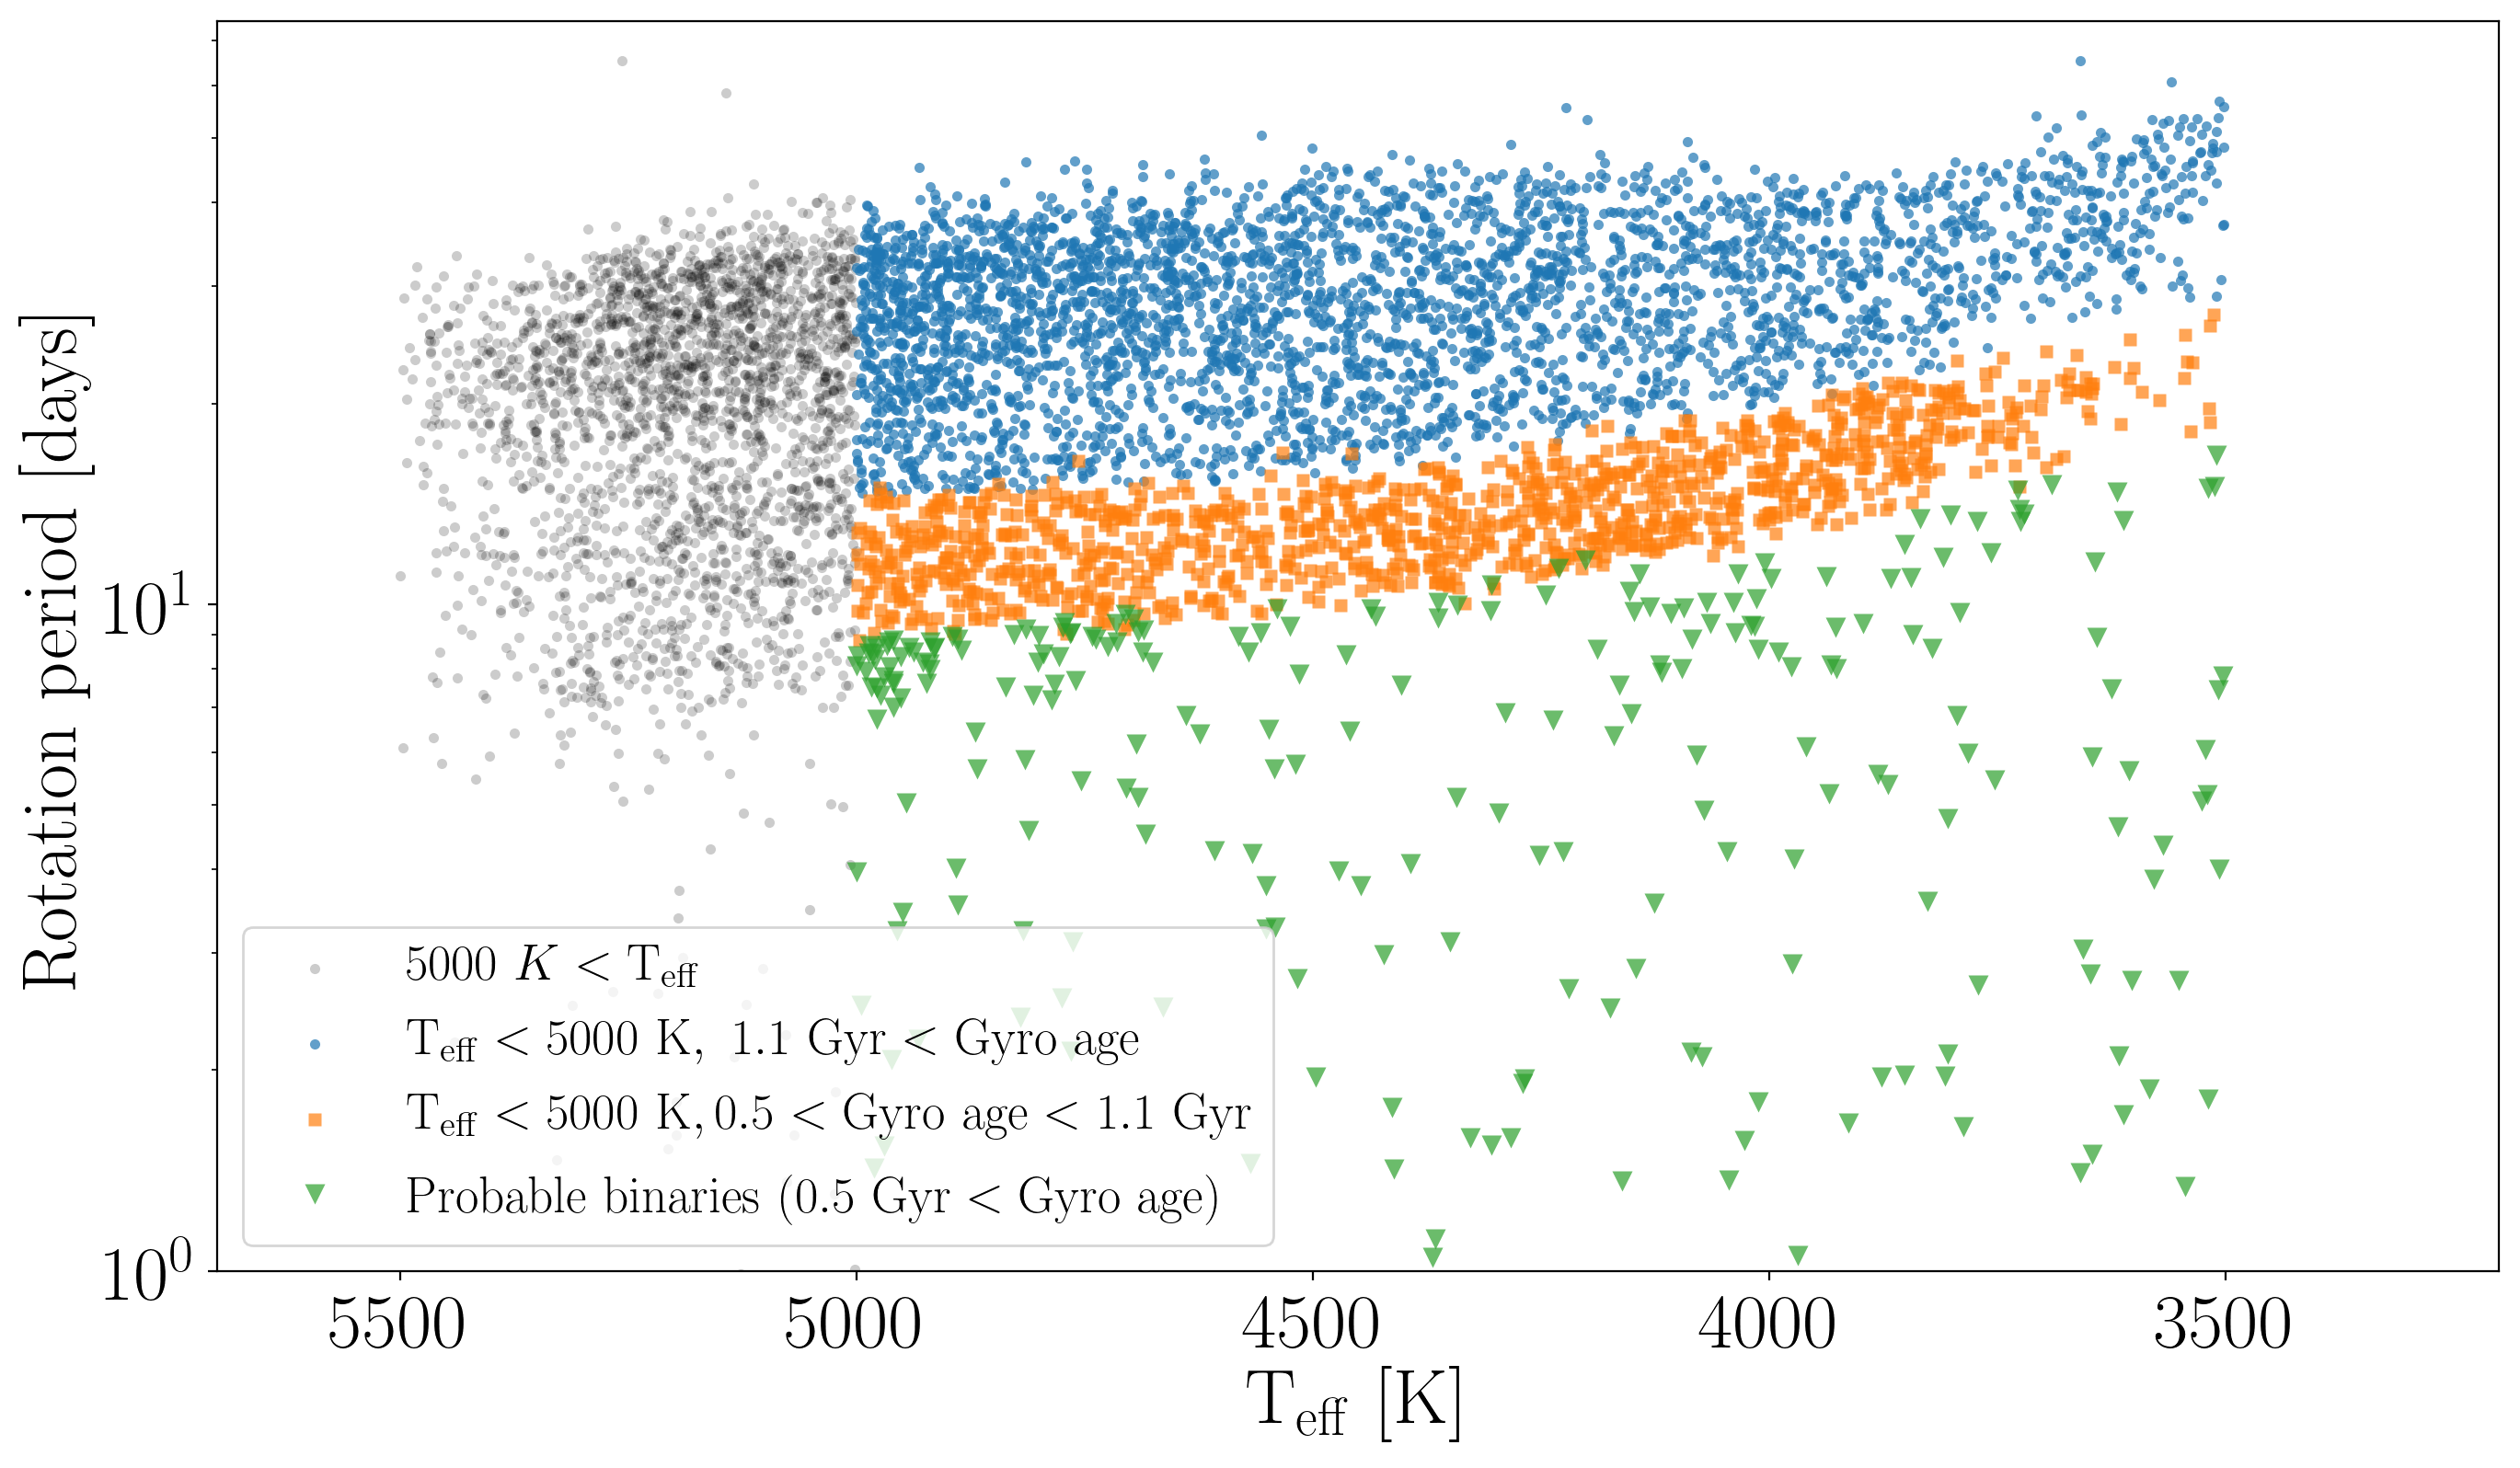

In [7]:
plt.figure(figsize=(16, 9), dpi=200)

# All McQuillan-Gaia stars
plt.plot(gaia_mc.color_teffs[~everything_else], gaia_mc.Prot[~everything_else],
         "k.", zorder=0, alpha=.2, mec="none", ms=8, rasterized=True, label="$5000~K < \mathrm{T_{eff}}$")

# Old stars
plt.plot(gaia_mc.color_teffs[old], gaia_mc.Prot[old],
         "C0.", zorder=1, ms=8, mec="none", alpha=.7, rasterized=True,
         label="$\mathrm{T_{eff} < 5000~K,~1.1~Gyr < Gyro~age}$")

# Young stars
plt.plot(gaia_mc.color_teffs[young], gaia_mc.Prot[young],
         "C1s", zorder=1, ms=5, mec="none", alpha=.7, rasterized=True,
         label="$\mathrm{T_{eff} < 5000~K, 0.5 < Gyro~age < 1.1~Gyr}$")

# Binaries
plt.plot(gaia_mc.color_teffs[binaries], gaia_mc.Prot[binaries],
         "C2v", zorder=1, ms=8, mec="none", alpha=.7, rasterized=True,
         label="$\mathrm{Probable~binaries~(0.5~Gyr < Gyro~age)}$")

plt.legend()
plt.xlim(5700, 3200)
plt.ylim(1, 75)
plt.ylabel("$\mathrm{Rotation~period~[days]}$");
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.yscale("log")
# plt.savefig("period_teff.pdf")